In [1]:
import numpy as np
from skimage import io, color
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error

KeyboardInterrupt: 

### Importing one image

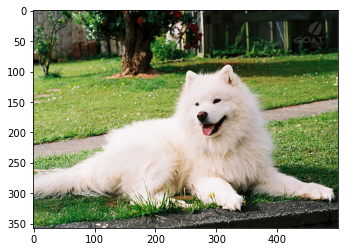

In [4]:
path = './samoyed-data/'
name = 'samoyed-10.jpg'
img = io.imread(path+name)
plt.imshow(img, cmap = 'gray')
plt.show()


### adding some noises

In [5]:
def addNoise(img, sigma=0.05):
    h,w,d = img.shape
    noisy_img = np.copy(img)
    for i in range(d):
         noisy_img[:,:,i] += np.array(sigma*np.random.randn(h,w)*255,dtype = 'uint8')
    return noisy_img

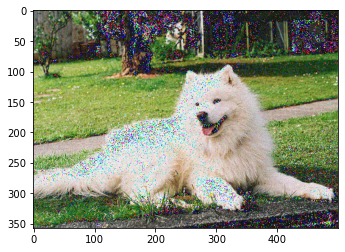

In [6]:
sigma=0.05 #std of noise added on original image
noisy_img = addNoise(img)
plt.imshow(noisy_img)
plt.show()

In [28]:
def nonLocalMeans(noisy,S, s, alpha, diag = True):
    
    p = S//2
    img = noisy.copy()
    
    h,w = img.shape
    
    # we need to reshape a bit the image to avoid index errors
    p_img = np.zeros((h + S,w + S),dtype ='uint8' ) # we initialize the image
    p_img[p:p+h, p:p+w] = img # the center of this new image is the image noisy
    p_img[p:p+h, 0:p] = np.fliplr(img[:,0:p]) # the part at the left is the reflection of the image
    p_img[p:p+h, w+p:w+2*p] = np.fliplr(img[:,w-p:w]) # same for the tight part
    p_img[0:p,:] = np.flipud(p_img[p:2*p,:]) # and for the top
    p_img[p+h:2*p+h, :] =np.flipud(p_img[p_img.shape[0] - 2*p:p_img.shape[0] - p,:]) # and bottom

    output_img = p_img.copy()

    s_half = s//2
    
    if diag: #if we want to see the progress bar
        for x in tqdm(range(p, p + img.shape[1])):
            for y in range(p, p + img.shape[0]): #for each pixel in the image

                cornerX = x - p #coord of the left upper corner of the crop centered at (x,y)
                cornerY = y - p #coord of the left upper corner of the crop centered at (x,y)

                crop = p_img[y - s_half:y + s_half + 1,x-s_half:x+s_half + 1] # we take a crop  around (x,y) of shape (s,s)

                pixel = 0 # new value for the pixel at (x,y)
                totalWeight = 0 # sum of the weight of the pixel
                
                for xx in range(cornerX, cornerX + S - s, 1):
                    for yy in range(cornerY, cornerY + S - +s, 1): #for every pixel in around the pixel (x,y)    
                        patch = p_img[yy:yy+s + 1,xx:xx+s + 1] #we pick up another crop of the same size 
                        dist = np.sqrt(np.sum(np.square(patch - crop))) # we compute the euclidian distance between those two crops
                        weight = np.exp(-dist/alpha) # we compute the weight of the pixel (yy + s_half, xx + s_half)
                        totalWeight += weight # we add the computed weight to the sum
                        pixel += weight*p_img[yy + s_half, xx + s_half] # we add the value of the pixel (yy + s_half, xx + s_half) multiplied by its weight

                pixel /= totalWeight
                output_img[y, x] = pixel
                
    else: #if we don't ask for a progress bar
        for x in range(p, p + img.shape[1]):
            for y in range(p, p + img.shape[0]): #for each pixel in the image

                cornerX = x - p #coord of the left upper corner of the crop centered at (x,y)
                cornerY = y - p #coord of the left upper corner of the crop centered at (x,y)

                crop = p_img[y - s_half:y + s_half + 1,x-s_half:x+s_half + 1] # we take a crop  around (x,y) of shape (s,s)

                pixel = 0 # new value for the pixel at (x,y)
                totalWeight = 0 # sum of the weight of the pixel
                
                for xx in range(cornerX, cornerX + S - s, 1):
                    for yy in range(cornerY, cornerY + S - +s, 1): #for every pixel in around the pixel (x,y)    
                        patch = p_img[yy:yy+s + 1,xx:xx+s + 1] #we pick up another crop of the same size 
                        dist = np.sqrt(np.sum(np.square(patch - crop))) # we compute the euclidian distance between those two crops
                        weight = np.exp(-dist/alpha) # we compute the weight of the pixel (yy + s_half, xx + s_half)
                        totalWeight += weight # we add the computed weight to the sum
                        pixel += weight*p_img[yy + s_half, xx + s_half] # we add the value of the pixel (yy + s_half, xx + s_half) multiplied by its weight

                pixel /= totalWeight
                output_img[y, x] = pixel
    return output_img[p:p+h,p:p+w]


In [31]:
output_img = []
for i in range(3):
    output_img.append(nonLocalMeans(noisy_img[:,:,i],10,8,7))
output_img = np.array(output_img).transpose(1,2,0)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 47.10it/s]


noisy psnr:  14.569306090588103 

denoised psnr 14.60165766807761
noisy mse:  2270.6476732026144 

denoised mse 2253.795949579832


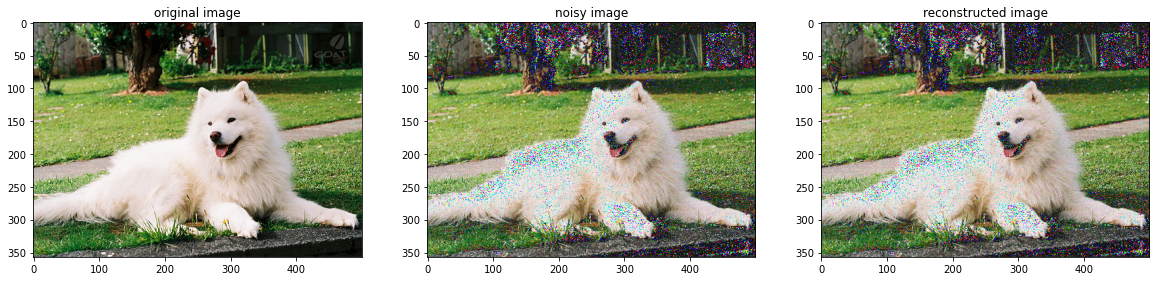

In [32]:
#Plotting results
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(img)
plt.title("original image")
plt.subplot(132)
plt.imshow(noisy_img)
plt.title("noisy image")
plt.subplot(133)
plt.imshow(output_img)
plt.title("reconstructed image")

#Comparing psnr score
psnr_noisy=peak_signal_noise_ratio(img,noisy_img)
print("noisy psnr: ",psnr_noisy,"\n")
psnr_denoised=peak_signal_noise_ratio(img,output_img)
print("denoised psnr",psnr_denoised)
mse_noisy=mean_squared_error(img,noisy_img)
print("noisy mse: ",mse_noisy,"\n")
mse_denoised=mean_squared_error(img,output_img)
print("denoised mse",mse_denoised)

### Test over the whole dataset

In [14]:
def load_data(id):
    path = './samoyed-data/'
    name = 'samoyed-{}.jpg'.format(id)
    img = io.imread(path+name)
    return img

def NLM(S = 10, s = 4, h = 7, n = 50, sigma = 0.05):
    
    psnr_noisy = []
    psnr_denoised = []
    mse_noisy = []
    mse_denoised = []
    
    for id_img in tqdm(range(1,n+1)):
        img = load_data(id_img)
        noisy_img = addNoise(img,sigma)
        output_img = []
        for i in range(3):
            output_img.append(nonLocalMeans(noisy_img[:,:,i],S,s,h,False))
        output_img = np.array(output_img).transpose(1,2,0)
        psnr_noisy.append(peak_signal_noise_ratio(img,noisy_img))
        psnr_denoised.append(peak_signal_noise_ratio(img,output_img))
        mse_noisy.append(mean_squared_error(img,noisy_img))
        mse_denoised.append(mean_squared_error(img,output_img))
    return psnr_denoised,psnr_noisy,mse_denoised,mse_noisy

In [15]:
psnr_denoised,psnr_noisy,mse_denoised,mse_noisy = NLM(n = 10)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [37:31<00:00, 225.12s/it]


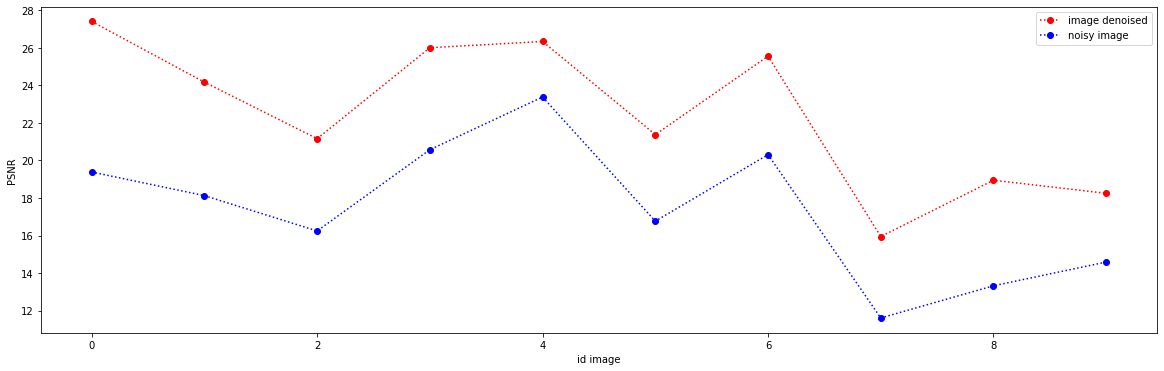

In [16]:
plt.figure(figsize=(20,6) )
plt.plot(psnr_denoised,'o:r', label='image denoised')
plt.plot(psnr_noisy,'o:b', label = 'noisy image')
plt.xlabel("id image")
plt.ylabel("PSNR")
plt.legend()
plt.show()

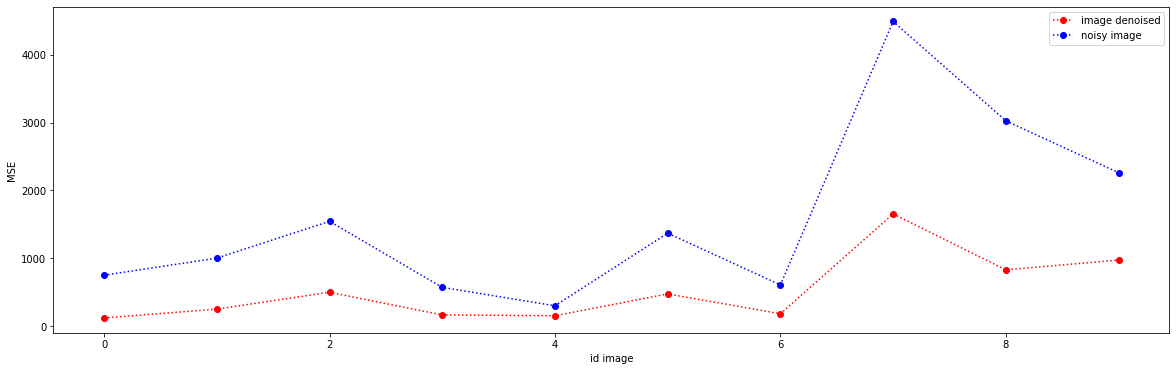

In [17]:
plt.figure(figsize=(20,6) )
plt.plot(mse_denoised,'o:r', label='image denoised')
plt.plot(mse_noisy,'o:b', label = 'noisy image')
plt.xlabel("id image")
plt.ylabel("MSE")
plt.legend()
plt.show()